In [80]:

# !pip install mlflow==1.24.0
# !pip install pystan==2.19.1.1
# !pip install prophet==1.0

# %pip install protobuf==3.20.*
# %matplotlib inline

In [81]:

import mlflow
import json
import pandas as pd
import numpy as np
from prophet import Prophet, serialize
from prophet.diagnostics import cross_validation, performance_metrics
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

ARTIFACT_PATH = "model"
np.random.seed(12345)

In [82]:
tracking_server_uri = "http://138.68.70.41:5000"  # set to your server URI

try:
    mlflow.set_tracking_uri(tracking_server_uri)
except:
    print(
        """Couldn't connect to remote MLFLOW tracking server""")

In [83]:
# SOURCE_DATA_WEATHER = (
#     'https://raw.githubusercontent.com/rkrikbaev/operator/dev/jupyter/project/power/weather_2016_2020_daily.csv'
# )
# df_regressor = pd.read_csv(SOURCE_DATA_POWER, sep=',')
# df_regressor.info()

In [84]:
SOURCE_DATA_POWER = (
    'https://raw.githubusercontent.com/rkrikbaev/operator/dev/jupyter/project/power/AEP_hourly.csv'
)

label='AEP_MW'

df_raw = pd.read_csv(SOURCE_DATA_POWER, sep=',', index_col=[0], parse_dates=[0])[[label]].tail(-1)

In [112]:

def extract_params(pr_model):
    return {attr: getattr(pr_model, attr) for attr in serialize.SIMPLE_ATTRIBUTES}

def create_df(data, ext_columns):
    
    columns = ['ds', 'y']

    if ext_columns:
      columns.extend(ext_columns)
    
    df = pd.DataFrame(data)
    
    if columns:
      rename_columns = {index: x for index, x in enumerate(columns)}

    df.rename(columns=rename_columns, inplace=True)
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]], unit='ms')
    df.reset_index(inplace=True, drop=True)

    return df


def create_features(df, label, holidays, fields):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['dt'] = df.index
    df['hour'] = df['dt'].dt.hour
    df['dayofweek'] = df['dt'].dt.dayofweek
    df['quarter'] = df['dt'].dt.quarter
    df['month'] = df['dt'].dt.month
    df['year'] = df['dt'].dt.year
    df['dayofyear'] = df['dt'].dt.dayofyear
    df['dayofmonth'] = df['dt'].dt.day
    df['weekofyear'] = df['dt'].dt.weekofyear
    df['date'] = df['dt'].dt.date

    df['isweekend'] = df['dayofweek'].apply(
        lambda x: 1 if (x in [5, 6]) else -1)
    
    if holidays:
      holidays = [datetime.strptime(x, '%Y-%m-%d').date() for x in holidays]
      df['isholiday'] = np.where(df['date'].isin(holidays), 1, -1)

    X = df[fields]
    if label:
        y = df[label]
        return X, y

    return X


In [118]:
#optional

holidays = []

# 'hour', 'dayofweek', 'quarter', 'month','year', 'dayofyear', 'dayofmonth', 'weekofyear'
fields = []

X, y = create_features(df_raw, label, holidays, fields)
df = pd.concat([X, y], axis=1)

# mean normalization
df_normalized = (df-df.mean())/df.std()

# min/max normalization
# df_normalized = (df-df.mean()) / \
#     (df.max() - df.min())

df_normalized.describe()



/var/folders/j_/fd4wtlp50b3ghh0lmpt68myr0000gn/T/ipykernel_4390/72444439.py:36: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['dt'].dt.weekofyear


,AEP_MW
count,1.212720e+05
mean,1.443678e-16
std,1.000000e+00
min,-2.283909e+00
25%,-7.214355e-01
50%,-7.313813e-02
75%,6.561965e-01
max,3.934343e+00


<AxesSubplot:title={'center':'Regressors'}, xlabel='Datetime'>

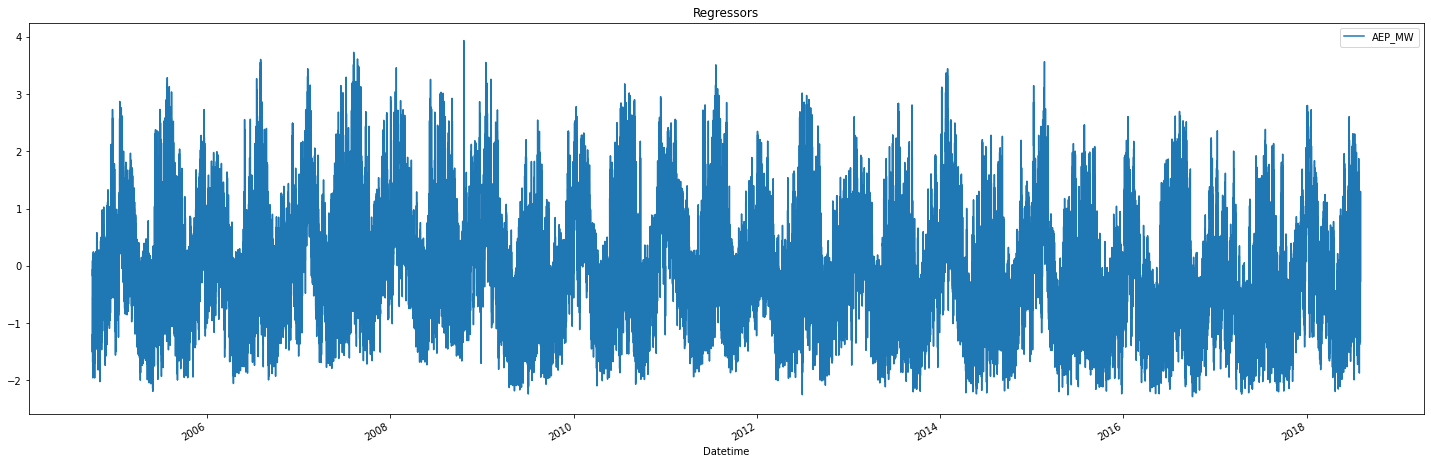

In [119]:
fields.append(label)

features_and_target_plot = df_normalized[
    fields].copy()
features_and_target_plot.plot(figsize=(25,8), title='Regressors', style='-')

In [ ]:
# optional
# sns.pairplot(df.dropna(),
#              hue='hour',
#              x_vars=['hour','dayofweek',
#                      'year','weekofyear'],
#              y_vars=label,
#              height=5,
#              plot_kws={'alpha':0.15, 'linewidth':0}
#             )
# plt.suptitle('Power Use MW by Hour, Day of Week, Year and Week of Year')
# plt.show()

## experiment

Train/Test Split


df_train: 97.0013037809648, 744

df_test: 2.9986962190352022, 23


<AxesSubplot:title={'center':'Power'}, xlabel='Datetime'>

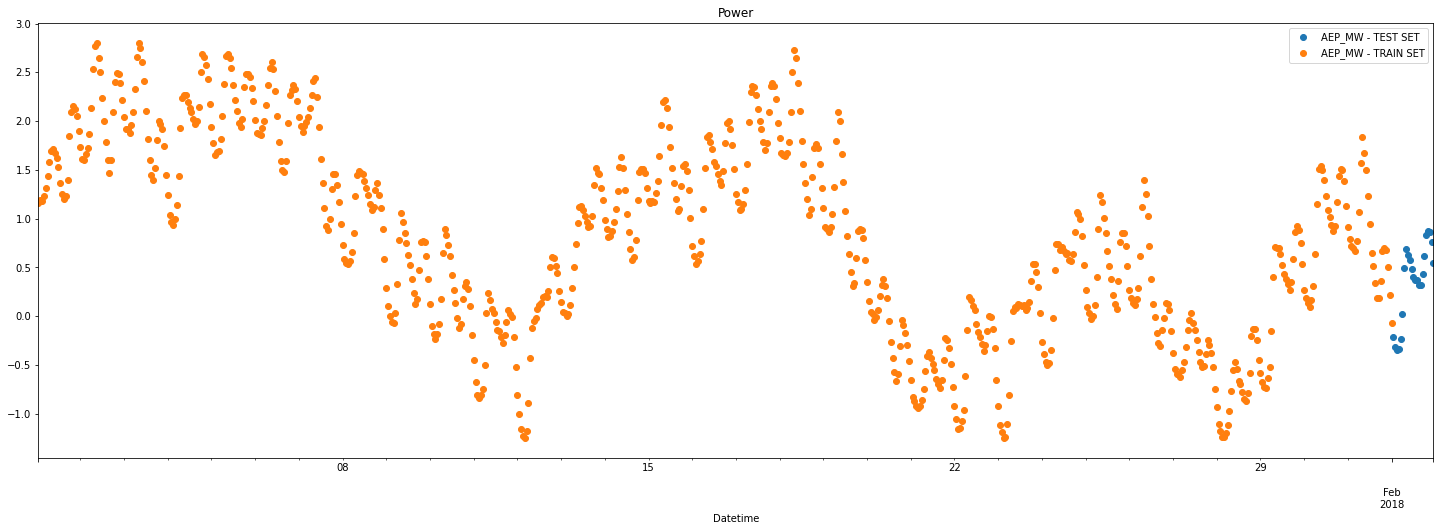

In [153]:
start_date = '01-Jan-2018'
split_date = '01-Feb-2018'
end_date = '02-Feb-2018'

df = df_normalized.copy()

df = df.loc[df.index > start_date].copy()
df = df.loc[df.index < end_date].copy()

df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

# df_test = df_test[df_test.index < end_date].copy()

df_train_per = df_train.shape[0]*100/df.shape[0]
df_test_per = df_test.shape[0]*100/df.shape[0]                     

print()
print(f'df_train: {df_train_per}, {df_train.shape[0]}')
print()
print(f'df_test: {df_test_per}, {df_test.shape[0]}')

# Plot train and test so you can see where we have split

# other = df.rename(columns={label: 'WHOLE DATASET'})

# df_test \
#     .rename(columns={label: 'TEST DATASET'}) \
#     .join(other,
#           rsuffix='_other',
#           how='outer') \
#     .plot(figsize=(25, 8), title='Power', style='-')
# plt.show()


# df_test \
#     .rename(columns={label: 'TEST SET'}) \
#     .join(df_train.rename(columns={label: 'TRAINING SET'}),
#           how='outer') \
#     .plot(figsize=(25,8), title='Power', style='-')
# plt.show()

df_test.rename(columns={label: label + ' - TEST SET'}).join([
    df_train.rename(columns={label: label + ' - TRAIN SET'})], how='outer').plot(figsize=(25,8), title='Power', style='o', subplots=False)

In [154]:
horizon = 30
period = 60
initial = 365*24
step = 'hours'

mlflow.set_experiment("almaty")
experiment = mlflow.get_experiment_by_name("almaty")

with mlflow.start_run(experiment_id=experiment.experiment_id):

    model = Prophet(
        # growth="linear",
        # seasonality_mode='multiplicative',
        # changepoint_prior_scale=30,
        # seasonality_prior_scale=35,
        # interval_width=0.98,
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=False
        )
    
    # model.add_seasonality(name='yearly', period=1, fourier_order=1)
    model.add_seasonality(name='weekly', period=1, fourier_order=1)
    model.add_seasonality(name='daily', period=1, fourier_order=1)
    model.add_seasonality(name='hourly', period=1, fourier_order=1)

    # model regressors 'isholiday', 'isweekend'
    # for item in fields:
    #     model.add_regressor(item)

    # print(df_train.head)
    model.fit(df_train.reset_index().rename(columns={'Datetime':'ds',label:'y'}))
    
    # params = extract_params(model)
    # metric_keys = ["mse", "rmse", "mae", "mape", "mdape", "smape", "coverage"]

    # metrics_raw = cross_validation(
    #     model=model,
    #     horizon= f"{horizon} {step}",
    #     period= f"{period} {step}",
    #     initial= f"{initial} {step}",
    #     parallel="threads",
    #     disable_tqdm=True,
    # )

    # cv_metrics = performance_metrics(metrics_raw)
    # metrics = {k: cv_metrics[k].mean() for k in metric_keys}

    # print(f"Logged Metrics: \n{json.dumps(metrics, indent=2)}")
    # print(f"Logged Params: \n{json.dumps(params, indent=2)}")

    mlflow.prophet.log_model(model, artifact_path=ARTIFACT_PATH)
    # mlflow.log_params(params)
    # mlflow.log_metrics(metrics)
    model_uri = mlflow.get_artifact_uri(ARTIFACT_PATH)
    print(f"Model artifact logged to: {model_uri}")

Initial log joint probability = -39.2576
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       639.481   1.04143e-05       86.5687     0.00928           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       639.492   6.07395e-05       67.0234    8.55e-07       0.001      184  LS failed, Hessian reset 
     146       639.498   1.22966e-08       67.1612       0.178       0.178      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Model artifact logged to: file:///usr/local/etc/1/ffd6b11a46bb4f768e23ff4b23194ff4/artifacts/model


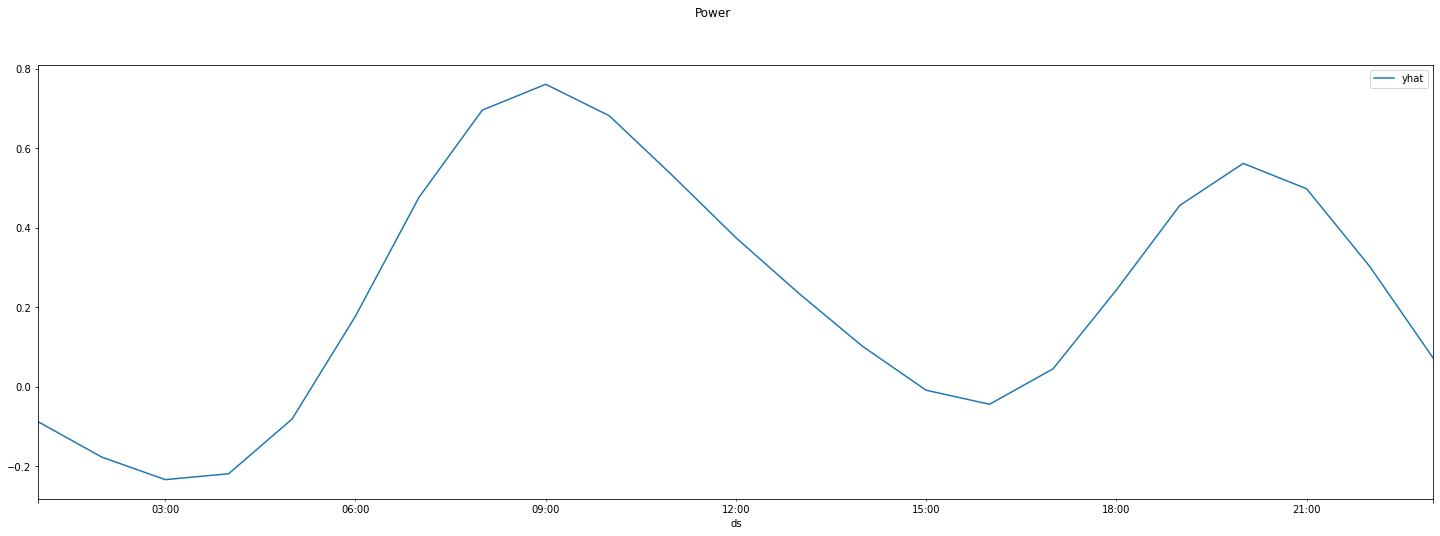

In [148]:
# Predict on training set with model

forecast = model.predict(
    df=df_test.reset_index().rename(columns={'Datetime': 'ds'}))

# Plot the forecast

df_forecast = forecast[['ds', 'yhat']].copy()
df_forecast.set_index('ds', inplace=True)

df_forecast.plot(figsize=(25, 8), title='Power', style='-', subplots=True)
plt.show()


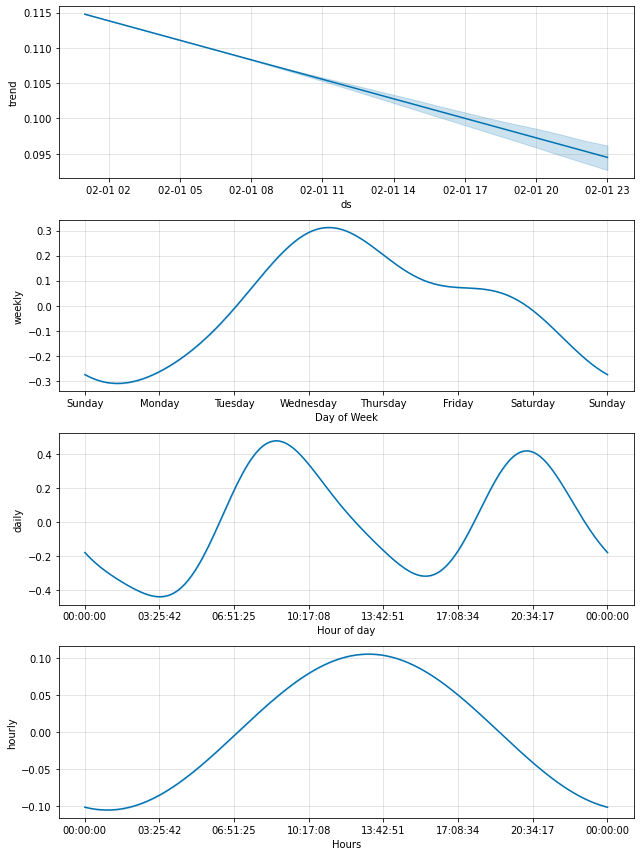

In [149]:
# Plot the components of the model
fig = model.plot_components(forecast)


# Compare Forecast to Actuals

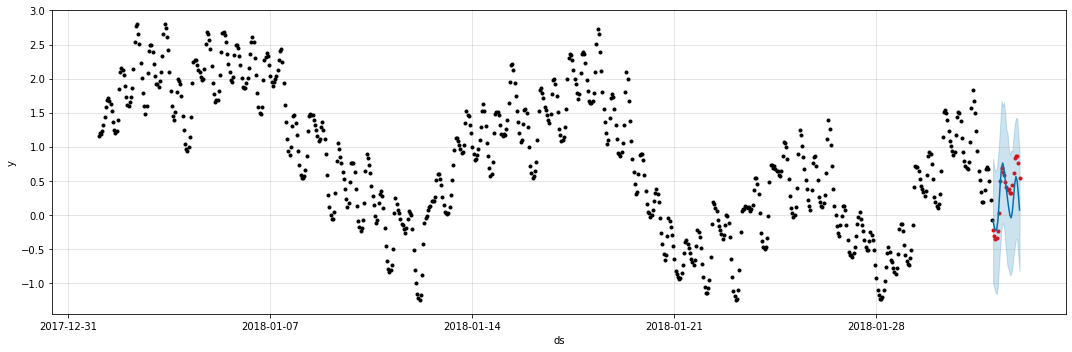

In [150]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['AEP_MW'],
           color='r', linestyle='solid', marker='.')
fig = model.plot(forecast, ax=ax)


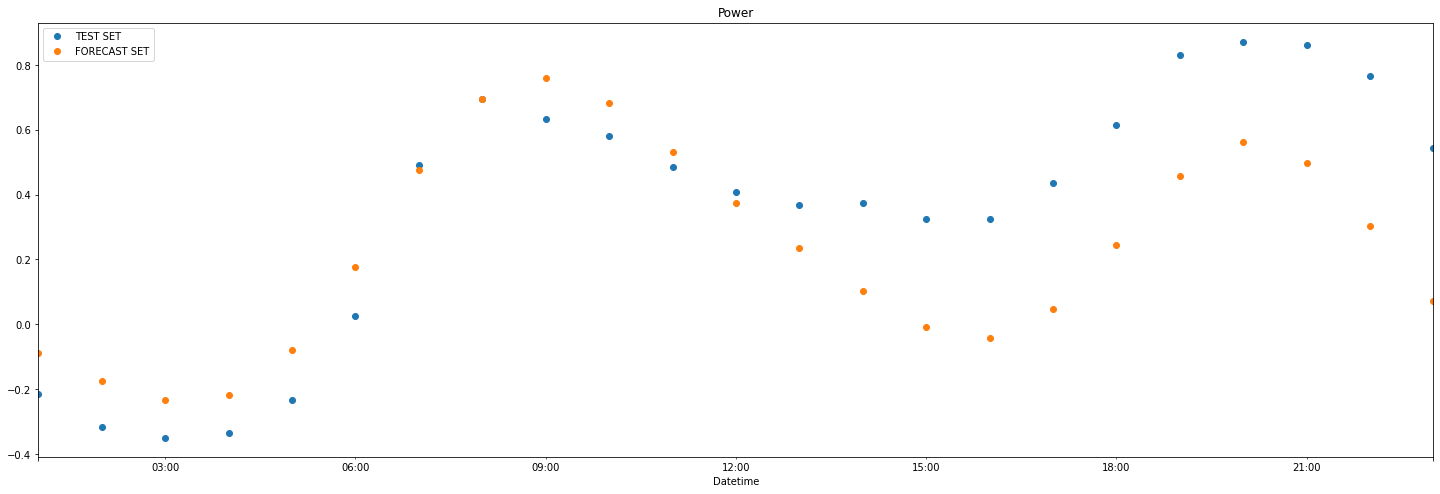

In [151]:
df_forecast = forecast[['ds','yhat']].copy()
df_forecast.set_index('ds', inplace=True)

df_test \
    .rename(columns={label: 'TEST SET'}) \
    .join(df_forecast.rename(columns={'yhat': 'FORECAST SET'}),
          how='outer') \
    .plot(figsize=(25, 8), title='Power', style='o', subplots=False)
plt.show()


In [ ]:
df_test.rename(columns={label: label + ' - TEST SET'}).join([
    df_train.rename(columns={label: label + ' - TRAIN SET'})], how='outer').plot(figsize=(25,8), title='Power', style='o', subplots=False)

#

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
ax.scatter(df_test.index, df_test['AEP_MW'], color='r')
fig = model.plot(forecast, ax=ax)
# ax.set_xbound(lower='2018-01-01 01:00:00', upper='2018-02-01 01:00:00')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2018 Forecast vs Actuals')


In [ ]:
from datetime import datetime, timedelta

periods = 96
date_time_str = '2018-01-01 01:00:00'

ini_time_for = datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
date = ini_time_for - timedelta(hours=periods)
# create an array of 5 dates starting at '2015-02-24', one per minute
range = pd.date_range(date, periods, freq='H')
future = pd.DataFrame({'ds': range})

# Predict on training set with model
forecast = model.predict(future)

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(forecast,
                 ax=ax)
plt.show()
